In [7]:
import scipy.io
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import cv2
import os


In [8]:
class BData():
    def __init__(self, skeleton_location, VGG_location, video_location):
        print("Loading data")
        self.skelly = []
        self.skeleton = np.array(
            scipy.io.loadmat(skeleton_location)["skeldata"])[:, 1:].transpose()
        self.VGG = np.array(scipy.io.loadmat(
            VGG_location)["features"]).transpose()
        self.load_video(video_location)

    def center_data(self, df):
        print()
        print("Centering data")
        # center the data
        df = df - df.mean()
        return df

    def EDA_VGG(self):
        print()
        print("VGG EDA")
        self.VGG_df = pd.DataFrame(self.VGG)
        print(self.VGG_df.describe())

    def EDA_skelly(self):
        print()
        print("Skelly EDA")

        # index obtains the indexes of the columns by concatenating the strings "x", "y" and "p" with the numbers 1 to 18
        # and then concatenating the strings with the numbers 1 to 6 and putting them in a list
        index = [j+str(i+1) for i in range(int((self.skeleton[0, :].shape[0]-1)/3))
                 for j in ["x", "y", "p"]]
        # skeleton_df is a dataframe with the skeleton data and the indexes are the columns
        self.skeleton_df = pd.DataFrame(
            self.skeleton, columns=["f", *index])
        # describe the data
        # plot the data
        max_frame = max([
            self.skeleton_df[self.skeleton_df.f == i].shape[0] for i in range(int(self.skeleton_df["f"].max()))])
        # ts = self.skeleton_df.plot.scatter(x='x1', y='y1')
        # ts.plot()
        # plt.show()

        skelly_aux = []
        for i in range(18):
            # drop the p of the joints
            self.skeleton_df = self.skeleton_df.drop(
                columns=["p"+str(i+1)])

        skelly_aux = []
        for i in range(int(self.skeleton_df["f"].max())):
            # skelly is a dataframe with the skeleton data of the frame i
            skelly = self.skeleton_df[self.skeleton_df.f == i].drop(
                columns="f")
            middle_point = np.array([skelly["x1"],
                                     skelly["y1"]])
            if middle_point.shape[1] == 0:
                n = 0
                mean = [0]*34
                variance = [0]*34

            else:
                n = len(middle_point)
                skelly = skelly.drop(
                    columns=["x1", "y1"]).transpose().values.reshape(
                    -1, middle_point.shape[1]*2)
                skelly = ((skelly-middle_point.reshape(1, -1))
                          ).transpose().reshape(-1, 34)
                mean = skelly.mean(axis=0)

                variance = skelly.var(axis=0)

            # autocorrolation_string = []

            skelly_aux.append([n, *mean, *variance])

        self.skeleton_df = pd.DataFrame(
            skelly_aux)

    def PCA_VGG(self):
        print()
        print("PCA VGG")
        print(np.linalg.matrix_rank(self.VGG_df))

        steps = [('scaling', StandardScaler()),
                 ('pca', PCA(n_components=0.9))]
        # create the pipeline
        pipeline = Pipeline(steps)
        # fit the pipeline
        pipeline.fit(self.VGG_df)
        # transform the data
        reduced = pipeline.inverse_transform(
            pipeline.transform(self.VGG_df))
        # create a dataframe with the reduced data
        self.VGG_df = pd.DataFrame(reduced)
        # rank of vgg_df
        print(np.linalg.matrix_rank(self.VGG_df))

    def PCA_skelly(self):
        print()
        print("PCA Skelly")
        print(np.linalg.matrix_rank(self.skeleton_df))
        steps = [('scaling', StandardScaler()),
                 ('pca', PCA(n_components=0.90))]
        pipeline = Pipeline(steps)
        pipeline.fit(self.skeleton_df)
        reduced = pipeline.inverse_transform(
            pipeline.transform(self.skeleton_df))
        self.skeleton_df = pd.DataFrame(reduced)
        print(np.linalg.matrix_rank(self.skeleton_df))

    def kmeans(self, df, n_clusters=15):
        print()
        print("Kmeans")
        # apply kmeans with 6 clusters
        km = KMeans(n_clusters=n_clusters, n_init="auto").fit(df)
        # get the centroids of each cluster
        clusters = km.cluster_centers_
        # plot the data
        plt.figure(num=None, figsize=(10, 10), dpi=100,
                   facecolor='w', edgecolor='k')

        ax = plt.subplot(111, projection='3d')
        # another plot but 2d
        for i in range(6):
            ax.scatter(df[km.labels_ == i][0], df[km.labels_ == i][1],
                       df[km.labels_ == i][2], alpha=0.25, s=100, cmap='rainbow')
            # plot the centroid of each cluster
            ax.scatter(clusters[i, 0], clusters[i, 1],
                       clusters[i, 2], s=100, alpha=0.30, color="black")
            print("The centroid of the cluster number " + str(i) +
                  " is " + str(clusters[i, 0]) + " " + str(clusters[i, 1]))
            # find the frame with the minimum distance to the centroid
            min_dista = 1000000
            min_frame = 0
            for j in range(df[km.labels_ == i][0].shape[0]):
                dista = np.sqrt((df[km.labels_ == i][0].iloc[j] - clusters[i, 0])**2 + (df[km.labels_ == i]
                                [1].iloc[j] - clusters[i, 1])**2 + (df[km.labels_ == i][2].iloc[j] - clusters[i, 2])**2)
                if dista < min_dista:
                    min_dista = dista
                    min_frame = j
            print("The frame with the minimum distance to the centroid is " + str(min_frame) + " so the frame is in the minute " +
                  str(round(min_frame/60)) + " and second " + str(min_frame % 60) + " of the video")
        plt.show()
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        height, width, layers = self.video[1].shape
        # Codec (e.g., 'XVID', 'MJPG', 'mp4v')
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        fps = 5.0
        video = [cv2.VideoWriter(f"Videos/cluster{i}.mp4", fourcc, fps, (width, height))
                 for i in range(max(km.labels_)+1)]
        for k, image in enumerate(self.video):
            if k > len(km.labels_)-1:
                break
            label = km.labels_[k]
            video[label].write(image)
        for v in video:
            v.release()

    def t_SNE(self, df):
        print()
        print("t-SNE")
        # calculate the number of components of the t-SNE algorithm
        tsne = TSNE(n_components=2, perplexity=50, verbose=2).fit_transform(df)
        # plot the data
        plt.figure(num=None, figsize=(10, 10), dpi=100,
                   facecolor='w', edgecolor='k')
        # ax = plt.subplot(111, projection='3d')
        plt.scatter(tsne[:, 0], tsne[:, 1], alpha=0.25, s=100, cmap='rainbow')
        plt.show()

    def load_video(self, video_location):
        print("\nLoading Video")
        # Open the video fie
        video = cv2.VideoCapture(video_location)
        self.video = []

        # Check if the video was successfully opened
        if not video.isOpened():
            print('Error opening video file')
            return

        # Read and Save frames from the video
        while True:
            # Read a frame from the video
            ret, frame = video.read()

            if not ret:
                break

            # Save the frame
            self.video.append(frame)

        video.release()
        cv2.destroyAllWindows()

    def missing_data(self):
        #using a generalised low rank model to fill in missing data in the skeleton
        print()
        print("Missing Data")

        # index obtains the indexes of the columns by concatenating the strings "x", "y" and "p" with the numbers 1 to 18
        # and then concatenating the strings with the numbers 1 to 6 and putting them in a list
        index = [j+str(i+1) for i in range(int((self.skeleton[0, :].shape[0]-1)/3))
                 for j in ["x", "y", "p"]]
        # skeleton_df is a dataframe with the skeleton data and the indexes are the columns
        self.skeleton_df = pd.DataFrame(
            self.skeleton, columns=["f", *index])
        # describe the data
        # plot the data
        max_frame = max([
            self.skeleton_df[self.skeleton_df.f == i].shape[0] for i in range(int(self.skeleton_df["f"].max()))])
        # ts = self.skeleton_df.plot.scatter(x='x1', y='y1')
        # ts.plot()
        # plt.show()

        skelly_aux = []
        for i in range(18):
            # drop the p of the joints
            self.skeleton_df = self.skeleton_df.drop(
                columns=["p"+str(i+1)])
        #drop the frame column
        self.skeleton_df = self.skeleton_df.drop(columns=["f"])
        print(self.skeleton_df)

        #dataframe with the same size as the skeleton dataframe but with all the values 0
        mask = pd.DataFrame(np.ones(self.skeleton_df.shape), columns=self.skeleton_df.columns)
        
        # for each row of the dataframe check if xi,yi=0,0 and if it is true then put a 1 on the mask
        for i in range(self.skeleton_df.shape[0]):
            for j in range(round(self.skeleton_df.shape[1]/2)):
                if self.skeleton_df.iloc[i,2*j] == 0 and self.skeleton_df.iloc[i,2*j+1] == 0:
                    mask.iloc[i,2*j] = 0
                    mask.iloc[i,2*j+1] = 0

        # print(mask)

    #index is the vector of the indexes of the columns of the skeleton dataframe
    def base(self, index):
        skeleton_copy = self.skeleton_df.copy()

        base = skeleton_copy[:,index]
        base_ort = np.linalg.qr(base)[0]

        projection_base= np.zeros((skeleton_copy.shape[0], skeleton_copy.shape[1]))
        proj = np.zeros((skeleton_copy.shape[0], 1))
        new = np.zeros((skeleton_copy.shape[0],1))

        #for each vector in features
        for i in range(0,skeleton_copy.shape[1]):
            #calulate the projection of the vector in the base
            for j in range(0,base_ort.shape[1]):
                num= np.dot(skeleton_copy[:,i],base_ort[:,j])
                det = np.linalg.norm(base_ort[:,j])

                #calculate the projection
                new[:,0] = (num/det)*base_ort[:,j]
                proj[:,0]= np.add(proj[:,0],new[:,0])
            
            #something wrong with the projection for sure......     
            #add the projection to the projection base 
            projection_base[:,i]= proj[:,0].T
            proj = np.zeros((skeleton_copy,1))

        projection_perpendicular = np.zeros((skeleton_copy.shape[0],skeleton_copy.shape[1]))
        projection_perpendicular = np.subtract(skeleton_copy,projection_base)
        distance_to_base = np.zeros((skeleton_copy.shape[1],1))

        #distance to base of each vector in the coloumns
        for i in range(0,skeleton_copy.shape[1]):
            distance_to_base[i,0] = np.linalg.norm(projection_perpendicular[:,i])

        #create a vector with the each value has is own index
        index = np.zeros((skeleton_copy.shape[1],1))
        for i in range(0,skeleton_copy.shape[1]):
            index[i,0] = i

        #order the distance vector by the distance to the base
        distance_to_base = np.hstack((distance_to_base,index))
        distance_to_base = distance_to_base[distance_to_base[:,0].argsort()]
        #print(distance_to_base)

        #take the 10 best values of the distance vector
        best_values = distance_to_base[0:12,:]
        #print("best values-> ", best_values)
        #take the 100 worst values of the distance vector
        worst_values = distance_to_base[self.skeleton_df.shape[1]-12:self.skeleton_df.shape[1],:]
        #print("worst values-> ", worst_values)



Loading data

Loading Video

Skelly EDA

PCA Skelly
69
30

Centering data

Kmeans


/tmp/ipykernel_19005/354091099.py:125: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(df[km.labels_ == i][0], df[km.labels_ == i][1],


The centroid of the cluster number 0 is 0.31673086667177697 -0.03679206395905469
The frame with the minimum distance to the centroid is 181 so the frame is in the minute 3 and second 1 of the video
The centroid of the cluster number 1 is -1.2966233981478024 -0.09585486517849032
The frame with the minimum distance to the centroid is 0 so the frame is in the minute 0 and second 0 of the video
The centroid of the cluster number 2 is 0.565134209068886 0.39504811701796116
The frame with the minimum distance to the centroid is 111 so the frame is in the minute 2 and second 51 of the video
The centroid of the cluster number 3 is 0.3140055727026262 -0.08816935017238507
The frame with the minimum distance to the centroid is 97 so the frame is in the minute 2 and second 37 of the video
The centroid of the cluster number 4 is 0.6387258674636552 0.3239235886591805
The frame with the minimum distance to the centroid is 247 so the frame is in the minute 4 and second 7 of the video
The centroid of th

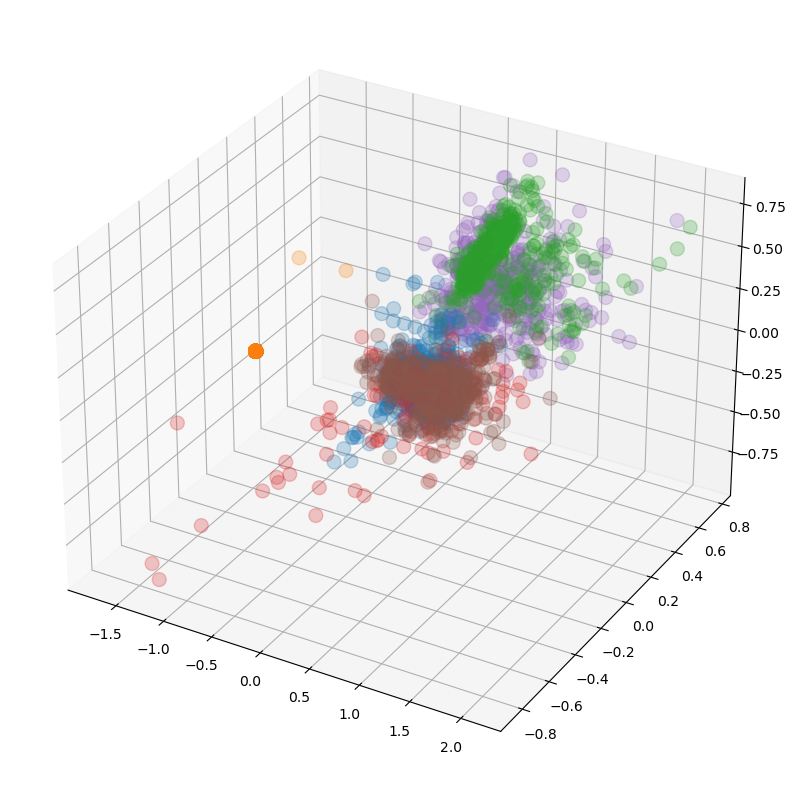


t-SNE
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10480 samples in 0.001s...
[t-SNE] Computed neighbors for 10480 samples in 28.610s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10480
[t-SNE] Computed conditional probabilities for sample 2000 / 10480
[t-SNE] Computed conditional probabilities for sample 3000 / 10480
[t-SNE] Computed conditional probabilities for sample 4000 / 10480
[t-SNE] Computed conditional probabilities for sample 5000 / 10480
[t-SNE] Computed conditional probabilities for sample 6000 / 10480
[t-SNE] Computed conditional probabilities for sample 7000 / 10480
[t-SNE] Computed conditional probabilities for sample 8000 / 10480
[t-SNE] Computed conditional probabilities for sample 9000 / 10480
[t-SNE] Computed conditional probabilities for sample 10000 / 10480
[t-SNE] Computed conditional probabilities for sample 10480 / 10480
[t-SNE] Mean sigma: 0.000000
[t-SNE] Computed conditional probabilities in 1.776s
[t-SNE] Iteration 50: error

/tmp/ipykernel_19005/354091099.py:168: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne[:, 0], tsne[:, 1], alpha=0.25, s=100, cmap='rainbow')


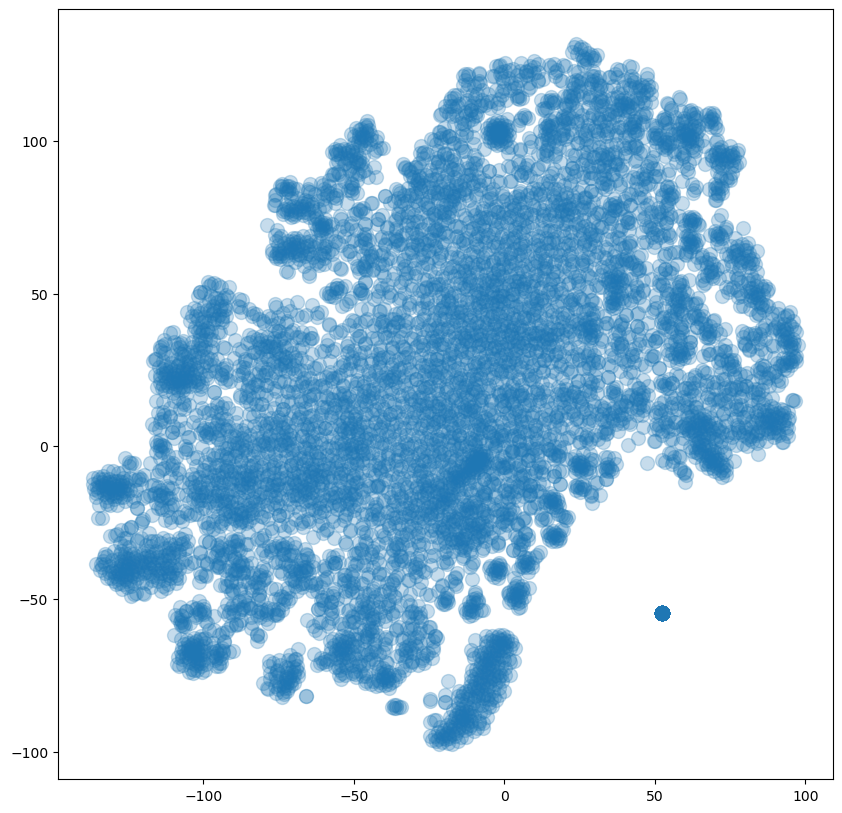

In [10]:
def main():
    data = BData("Data/girosmallveryslow2_openpose.mat",
                 "Data/girosmallveryslow2_vggfeatures.mat",
                 "Data/girosmallveryslow2.mp4")
    # data.EDA_VGG()
    # data.PCA_VGG()
    # data.VGG_df = data.center_data(data.VGG_df)
    # data.kmeans(data.VGG_df)
    data.EDA_skelly()
    data.PCA_skelly()
    data.skeleton_df = data.center_data(data.skeleton_df)
    data.kmeans(data.skeleton_df)
    # data.t_SNE(data.VGG_df)
    data.t_SNE(data.skeleton_df)


if __name__ == '__main__':
    main()
